In [1]:
# imports
from Phase_4_functions import roll_mean_std
from Phase_4_functions import decompose
from Phase_4_functions import DickeyFullerTest
from Phase_4_functions import naive_model
from Phase_4_functions import sarimax_search
from Phase_4_functions import fbprophet_func
from Phase_4_functions import LSTM_func
from Phase_4_functions import LSTM_val
from fbprophet import Prophet
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('fivethirtyeight')

In [3]:
df = pd.read_csv('../data/new_zillow_data.csv')

In [33]:
def melt_data(df):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    
    melted = pd.melt(df, id_vars=['RegionName', 'RegionID', 'SizeRank', 'City', 'State', 
                                  'Metro', 'CountyName', 'RegionType', 'StateName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted

In [34]:
melted = melt_data(df)
melted['time'] = pd.to_datetime(melted['time'])
melted.set_index('time', inplace=True)

## Zip Code 28546 (Jacksonville, NC)

### Plot the Rolling Mean and Rolling Std.

In [36]:
Jacksonville = melted[melted.RegionName == 28546]
Jacksonville

,RegionName,RegionID,SizeRank,City,State,Metro,CountyName,RegionType,StateName,value
time,,,,,,,,,,
2001-07-31,28546,70022,734,Jacksonville,NC,Jacksonville,Onslow County,Zip,NC,103652.0
2001-08-31,28546,70022,734,Jacksonville,NC,Jacksonville,Onslow County,Zip,NC,102163.0
2001-09-30,28546,70022,734,Jacksonville,NC,Jacksonville,Onslow County,Zip,NC,101544.0
2001-10-31,28546,70022,734,Jacksonville,NC,Jacksonville,Onslow County,Zip,NC,99843.0
2001-11-30,28546,70022,734,Jacksonville,NC,Jacksonville,Onslow County,Zip,NC,98744.0
...,...,...,...,...,...,...,...,...,...,...
2021-03-31,28546,70022,734,Jacksonville,NC,Jacksonville,Onslow County,Zip,NC,169281.0
2021-04-30,28546,70022,734,Jacksonville,NC,Jacksonville,Onslow County,Zip,NC,171288.0
2021-05-31,28546,70022,734,Jacksonville,NC,Jacksonville,Onslow County,Zip,NC,173431.0


In [5]:
Jacksonville = melted[melted.RegionName == 28546]
Jacksonville = Jacksonville.resample('MS').mean()
Jacksonville = Jacksonville.drop(['RegionName', 'RegionID', 'SizeRank'], axis=1)

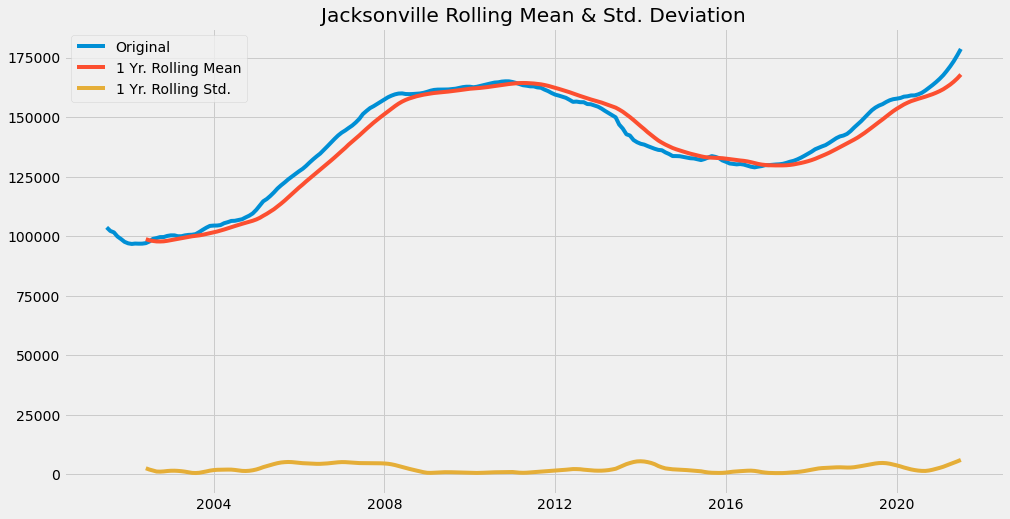

In [6]:
roll_mean_std(Jacksonville, name = 'Jacksonville')

This plot shows us that there is a positive trend in the data. There is no clear seasonality from this graph, will use a seasonal decompose next to see more information about the data.

### Seasonal Decompose

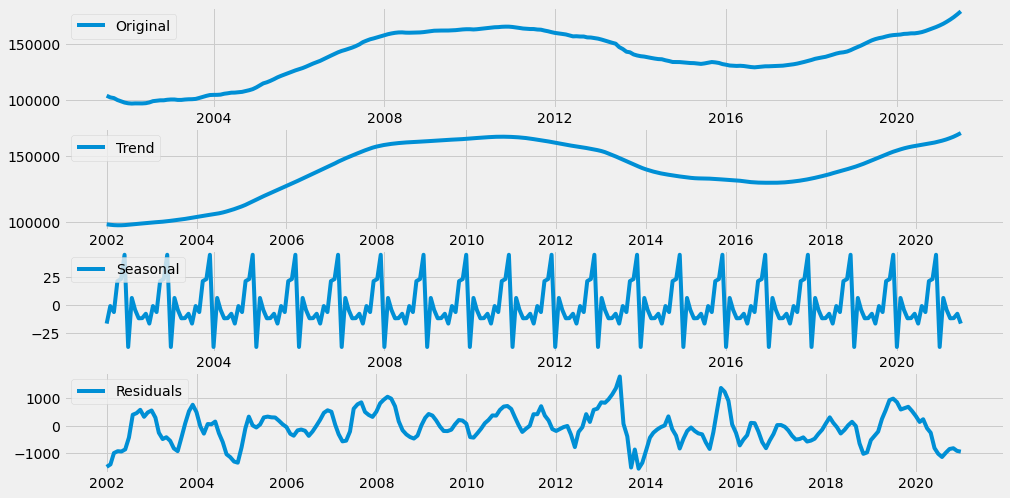

In [7]:
decompose(Jacksonville)

This seasonal decompose shows us more clearly that there is a clear positive linear trend in the data. There is also a seasonal aspect to the data. It would seem that more houses are sold in the summer months and less so in the winter months.

### Differencing and DickeyFuller Test

In [8]:
DickeyFullerTest(Jacksonville)

Test Statistic                  -1.162310
p-value                          0.689595
# Lags Used                     15.000000
Number of Observations Used    225.000000
Critical Value (1%)             -3.459752
Critical Value (5%)             -2.874473
Critical Value (10%)            -2.573663
dtype: float64

This dickey fuller test shows that the data are not stationary, the p-value is $0.69 > 0.05$, so we fail to reject the null hypothesis.

Test Statistic                  -0.747488
p-value                          0.834063
# Lags Used                     15.000000
Number of Observations Used    224.000000
Critical Value (1%)             -3.459885
Critical Value (5%)             -2.874531
Critical Value (10%)            -2.573694
dtype: float64

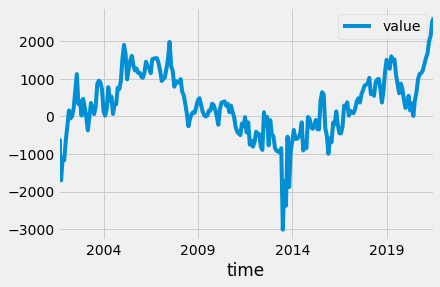

In [9]:
Jacksonville_diff = Jacksonville.diff().dropna()
Jacksonville_diff.plot()
DickeyFullerTest(Jacksonville_diff)

A first-order differential still does not make the data stationary. The p-value is $0.83$ still above the $0.05$ threshold. 

Test Statistic                  -4.525866
p-value                          0.000177
# Lags Used                     14.000000
Number of Observations Used    224.000000
Critical Value (1%)             -3.459885
Critical Value (5%)             -2.874531
Critical Value (10%)            -2.573694
dtype: float64

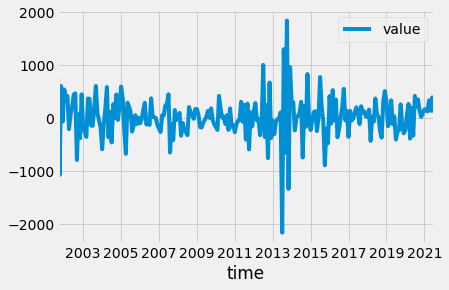

In [10]:
Jacksonville_diff2 = Jacksonville_diff.diff().dropna()
Jacksonville_diff2.plot()
DickeyFullerTest(Jacksonville_diff2)

A second-order differential does make the data stationary. The p-value is $0.00018$ still below the $0.05$ threshold so we can reject the null hyopthesis.

### ACF and PACF

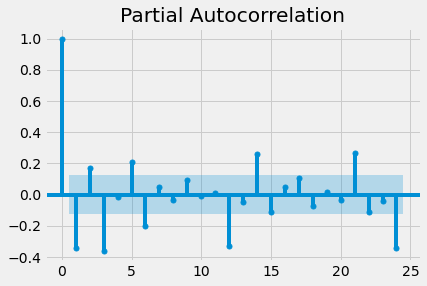

In [11]:
plot_pacf(Jacksonville_diff2);

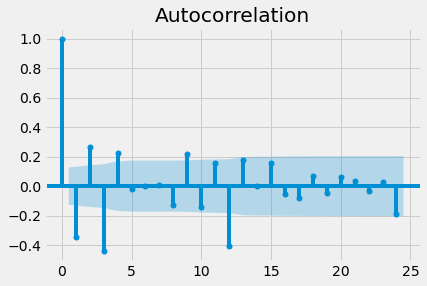

In [12]:
plot_acf(Jacksonville_diff2);

### Train Test Split

In [13]:
cutoff = round(Jacksonville.shape[0]*.8)
train = Jacksonville[:cutoff]
test = Jacksonville[cutoff:]

We will split it into a train and a test so we can build our next few models with the training data and use the test later on if the RMSE value for a specific model is the best RMSE overall.

### Naive Model

The Naive Model RMSE for the train data is: 814.46
The Naive Model RMSE for the test data is: 1153.37


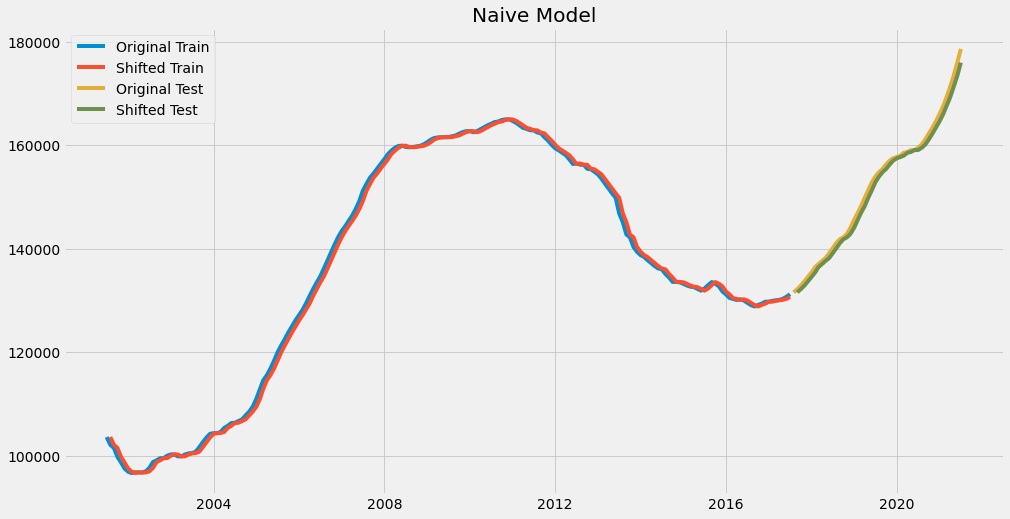

In [14]:
naive_model(train, test)

A naive model is our baseline model. Future models must have an RMSE lower than this to be seen as a viable model.

### Random Walk

In [15]:
random_walk_model = ARIMA(train, order=(0,1,0)).fit()
y_hat = random_walk_model.predict(type='levels')
RMSE = np.sqrt(mean_squared_error(train[1:], y_hat[1:]))
RMSE

814.4560588975933

### Auto ARIMA

In [16]:
auto_Jacksonville = pm.auto_arima(train, 
                                  start_p=0,
                                  start_q=0,
                                  max_p=10,
                                  max_q=10,
                                  d=None,
                                  seasonal=True,
                                  start_P=0,
                                  start_Q=0,
                                  max_P=10,
                                  max_Q=10,
                                  m=12,
                                  D=None,
                                  test='kpss',
                                  trace=True,
                                  stepwise=True,
                                  n_fits=1000)

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=2840.413, Time=0.02 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=2816.517, Time=0.07 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=2817.389, Time=0.28 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=2824.966, Time=0.03 sec
 ARIMA(1,2,0)(2,0,0)[12]             : AIC=2811.408, Time=0.44 sec
 ARIMA(1,2,0)(3,0,0)[12]             : AIC=2812.854, Time=1.29 sec
 ARIMA(1,2,0)(2,0,1)[12]             : AIC=2813.001, Time=1.71 sec
 ARIMA(1,2,0)(1,0,1)[12]             : AIC=2812.277, Time=0.50 sec
 ARIMA(1,2,0)(3,0,1)[12]             : AIC=2813.924, Time=4.00 sec
 ARIMA(0,2,0)(2,0,0)[12]             : AIC=2828.851, Time=0.35 sec
 ARIMA(2,2,0)(2,0,0)[12]             : AIC=2797.048, Time=0.51 sec
 ARIMA(2,2,0)(1,0,0)[12]             : AIC=2802.444, Time=0.27 sec
 ARIMA(2,2,0)(3,0,0)[12]             : AIC=2798.566, Time=1.41 sec
 ARIMA(2,2,0)(2,0,1)[12]             : AIC=2798.687, Time=1.04 sec
 ARIMA(2,2,0)(1,0,1

In [17]:
sarimax_model = SARIMAX(train, order=(2,1,0), seasonal_order=(0,0,0,12),
                       enforce_stationarity=False, enforce_invertability=False).fit()
yhat_train = sarimax_model.predict(type='levels')
RMSE = np.sqrt(mean_squared_error(train[2:], yhat_train[2:]))
RMSE

1159.2418089012026

The SARIMAX model has an RMSE of $1159.24$ which is less than the then naive model which had an RMSE of $814.46$.

### SARIMAX GridSearch and Model

In [18]:
sarimax_search(train, p=range(1,3), d=range(1,3), q=range(1,2), maxiter=100)

THERE ARE 16 ITERATIONS
Would you like to run the models? (y or n)?y
SARIMAX (1, 1, 1) x (1, 1, 1, 12) - RMSE:9764.515435531148
SARIMAX (1, 1, 1) x (1, 2, 1, 12) - RMSE:11661.64794952211
SARIMAX (1, 1, 1) x (2, 1, 1, 12) - RMSE:9305.689115467907
SARIMAX (1, 1, 1) x (2, 2, 1, 12) - RMSE:11329.228469236346
SARIMAX (1, 2, 1) x (1, 1, 1, 12) - RMSE:9771.810307568598
SARIMAX (1, 2, 1) x (1, 2, 1, 12) - RMSE:12815.15009179793
SARIMAX (1, 2, 1) x (2, 1, 1, 12) - RMSE:9694.593488401235
SARIMAX (1, 2, 1) x (2, 2, 1, 12) - RMSE:11739.032791878444
SARIMAX (2, 1, 1) x (1, 1, 1, 12) - RMSE:8860.994361171584
SARIMAX (2, 1, 1) x (1, 2, 1, 12) - RMSE:11434.030098820269
SARIMAX (2, 1, 1) x (2, 1, 1, 12) - RMSE:9478.48066212438
SARIMAX (2, 1, 1) x (2, 2, 1, 12) - RMSE:11073.715354267908
SARIMAX (2, 2, 1) x (1, 1, 1, 12) - RMSE:9865.482726142205
SARIMAX (2, 2, 1) x (1, 2, 1, 12) - RMSE:12368.272190948144
SARIMAX (2, 2, 1) x (2, 1, 1, 12) - RMSE:9895.865756937925
SARIMAX (2, 2, 1) x (2, 2, 1, 12) - RMSE:1

### Facebook Prophet Model

In [19]:
Jacksonville_proph = Jacksonville.reset_index()
Jacksonville_proph = Jacksonville_proph.rename(columns={'time':'ds', 'value':'y'})

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


RMSE for the train data: 687.4527445772102
%RMSE:  y    0.004942
dtype: float64


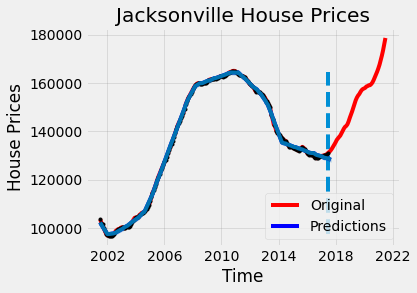

In [20]:
fbprophet_func(Jacksonville_proph, periods=2, city = 'Jacksonville')

The Prophet model has the best RMSE of all our models. We will use it to make our predictions.

### LSTM Model

In [21]:
history = LSTM_func(Jacksonville_proph, City='Jacksonville', epochs=200, verbose = 0, use_multiprocessing=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5, 64)             16896     
_________________________________________________________________
lstm_1 (LSTM)                (None, 5, 32)             12416     
_________________________________________________________________
lstm_2 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 32,465
Trainable params: 32,465
Non-trainable params: 0
_________________________________________________________________
RMSE: 2578.172482674906
%RMSE:  3172.9162721233215


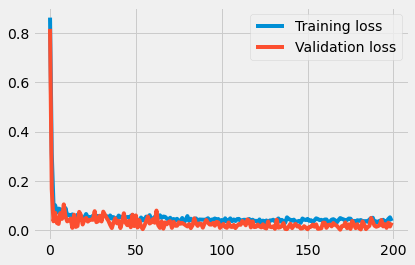

In [22]:
LSTM_val(history)

The LSTM has the worst of the RMSE values, we will ignore this model and use Prophet on the entire dataset to make future predictions.

# Best Model

#### Will now try and predict the value of houes 5 year from now using Prophet.

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


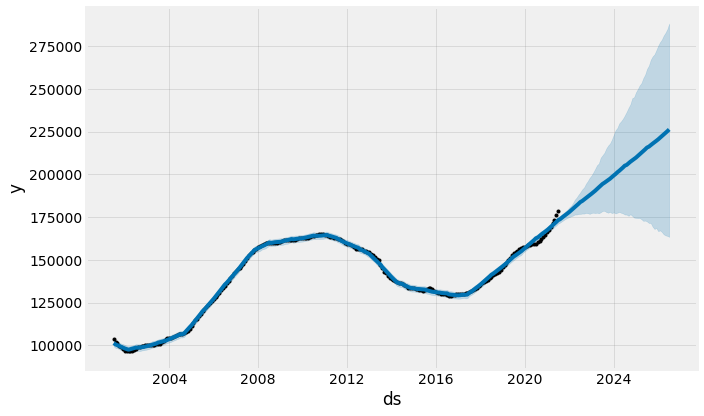

In [23]:
final_model = Prophet(interval_width=.95)
final_model.fit(Jacksonville_proph)
future_dates = final_model.make_future_dataframe(periods=60, freq='MS')
forecast = final_model.predict(future_dates)
final_model.plot(forecast, uncertainty=True);

In [24]:
Jacksonville_proph.max()

ds    2021-07-01 00:00:00
y                178594.0
dtype: object

In [25]:
future = forecast[forecast.ds >= '2021-07-01']

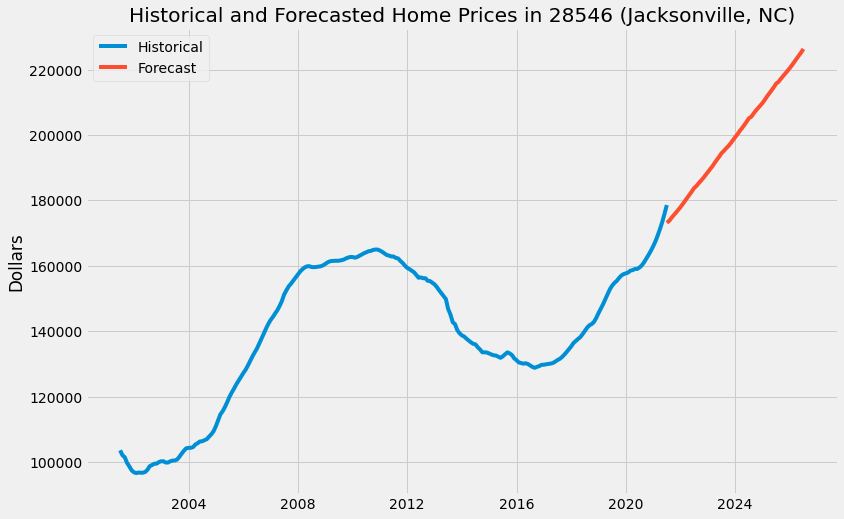

In [26]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(Jacksonville_proph.ds, Jacksonville_proph.y, label='Historical')
ax.plot(future.ds, future.yhat, label='Forecast')
ax.set_title('Historical and Forecasted Home Prices in 28546 (Jacksonville, NC)')
ax.set_ylabel('Dollars')
ax.legend();

In [27]:
current_price = int(Jacksonville_proph[Jacksonville_proph.ds == '2021-07-01'].y.values)
predicted_price = int(forecast[forecast.ds == '2026-07-01'].yhat.values)
pred_five_year_increase = predicted_price - current_price
five_year_roi = pred_five_year_increase / current_price
print(f'Current price:                ${current_price}')
print(f'Predicted 2026 price:         ${predicted_price}')
print(f'Predicted five year increase: ${pred_five_year_increase}')
print(f'Predicted five year ROI:      {five_year_roi}')

Current price:                $178594
Predicted 2026 price:         $226293
Predicted five year increase: $47699
Predicted five year ROI:      0.2670806410069767
